## Imports

In [1]:
import numpy as np
import csv, os
from os.path import join
import cv2
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]
from skimage.registration import phase_cross_correlation
import math
from sympy import symbols, Eq, solve

# Helper Functions

In [2]:
def get_rotation_matrix_inverse(angle: float):
    '''
    Input: Delta Rotation of the the stage in radians\n
    Output: Matrix of the shape:\n
    (2 - 2*cos(phi)) ** (-1) *  [ 1-cos(phi) , -sin(phi) ; sin(phi) , 1-cos(phi) ]
    '''    
    c,s = np.cos(angle), np.sin(angle)
    determinant = (2. - 2. * np.cos(angle)) ** -1
    matrix = np.matrix([[1.0 - c, -s], [ s, 1.0 - c]])
    return(determinant * matrix)

def get_rotation_matrix_offset(angle, origin = (0,0)):
    '''
    Input: Delta Rotation of the the stage in radians, Tuple of rotation center\n
    Output: npmy rotation Matrix 3x3
    '''
    c,s = np.cos(angle), np.sin(angle)
    x,y = origin[0], origin[1]
    matrix = np.array([[c, -s, x - c*x + s*y],[s , c,  y - s*x - c*y],[0,0,1]])
    return(matrix)

def phase_correlate(image_8bit, template_8bit, upsample_factor=25):

    # Determine image sizes
    image_height, image_width = image_8bit.shape
    template_height, template_width = template_8bit.shape
    target_height = max(image_height,template_height)
    target_width = max(image_width,template_width)

    # Pad to largest dimensions
    image_8bit_pad = np.zeros([target_height,target_width],dtype=np.uint8)
    image_8bit_pad[0:image_height,0:image_width] = image_8bit
    template_8bit_pad = np.zeros([target_height,target_width],dtype=np.uint8)
    template_8bit_pad[0:template_height,0:template_width] = template_8bit

    try:
        # Phase correlation with upsampled matrix-multiplication DFT
        shift, error, diffphase = phase_cross_correlation(template_8bit_pad, image_8bit_pad,upsample_factor=upsample_factor)
        match_center_x = template_width / 2 - shift[1]
        match_center_y = template_height / 2 - shift[0]
        transform = np.float32([ [1,0,shift[1]], [0,1,shift[0]] ])
    except NameError:
        # Phase correlation with Hanning window function and 5x5-weighted centroid around peak
        retval, response = cv2.phaseCorrelate(np.float32(template_8bit_pad), np.float32(image_8bit_pad))
        match_center_x = template_width / 2 + retval[0]
        match_center_y = template_height / 2 + retval[1]
        transform = np.float32([ [1,0,-retval[0]], [0,1,-retval[1]] ])
    image_8bit_pad_shifted = cv2.warpAffine(image_8bit_pad, transform, (target_width,target_height) )
    match_score = float(cv2.matchTemplate(template_8bit_pad, image_8bit_pad_shifted, cv2.TM_CCOEFF_NORMED)[0][0])

    return match_center_x, match_center_y, match_score

def printPositionNicely(p):
    print('Position / mm:\nx: {}\ny: {}\nz: {}\nt: {}\nr: {} {}'.format( \
        round(p['x']*1e3,4), round(p['y']*1e3,4), \
        round(p['z']*1e3,4), round(p['t']*57.2968,2),\
        round(p['r']/math.pi * 180 -360,2), \
        round(p['r']/math.pi * 180,2)))

# Load Sample Images and Data from Server

In [3]:
from pathlib import Path


folder = Path(r'\\samba-pool-plitzko2.biochem.mpg.de\pool-plitzko2\Johann\03-Data\06-FIB-SEM\220926_SampleDataRotation\final\220926_124443_1.0deg_360_MovementTest')
file = os.path.join(folder, 'position_data.csv')

In [4]:
try: 
    with open(file, mode='r') as f:
        reader = csv.DictReader(f)
        positions_str = list(reader)


    positions = [dict([a, float(x)] for a, x in b.items()) for b in positions_str]
    position_angles = [np.rad2deg(float(x['r'])) for x in positions_str]
    #print(positions)
    print(positions[0])
    #for i in range(len(positions)):
    #    print(positions[0])
    print(positions[0]['r']/math.pi*180 -360)
except: 
    print('Didn\'t work')
    pass

position_standard = {}
position_standard['x'] = -2.1915e-3
position_standard['y'] = -4.3908e-3
position_standard['z'] = 6.9725e-3
position_standard['t'] = 0.0
position_standard['r'] = 2*math.pi
positions_sorted = sorted(positions, key=lambda d: d['r']) 
#print(positions_sorted)

{'x': 0.0020254166666666667, 'y': 0.0050132499999999995, 'z': 0.035413323045267495, 'r': 6.283151012346053, 't': 0.0}
-0.001964949220507606


In [5]:
files = []
for file in os.listdir(folder):
    if file.endswith(".jpg"):
        if file.startswith('raw'):
            files.append(file)
            print(file)

raw_image_0.0deg.jpg
raw_image_1.0deg.jpg
raw_image_10.0deg.jpg
raw_image_100.0deg.jpg
raw_image_101.0deg.jpg
raw_image_102.0deg.jpg
raw_image_103.0deg.jpg
raw_image_104.0deg.jpg
raw_image_105.0deg.jpg
raw_image_106.0deg.jpg
raw_image_107.0deg.jpg
raw_image_108.0deg.jpg
raw_image_109.0deg.jpg
raw_image_11.0deg.jpg
raw_image_110.0deg.jpg
raw_image_111.0deg.jpg
raw_image_112.0deg.jpg
raw_image_113.0deg.jpg
raw_image_114.0deg.jpg
raw_image_115.0deg.jpg
raw_image_116.0deg.jpg
raw_image_117.0deg.jpg
raw_image_118.0deg.jpg
raw_image_119.0deg.jpg
raw_image_12.0deg.jpg
raw_image_120.0deg.jpg
raw_image_121.0deg.jpg
raw_image_122.0deg.jpg
raw_image_123.0deg.jpg
raw_image_124.0deg.jpg
raw_image_125.0deg.jpg
raw_image_126.0deg.jpg
raw_image_127.0deg.jpg
raw_image_128.0deg.jpg
raw_image_129.0deg.jpg
raw_image_13.0deg.jpg
raw_image_130.0deg.jpg
raw_image_131.0deg.jpg
raw_image_132.0deg.jpg
raw_image_133.0deg.jpg
raw_image_134.0deg.jpg
raw_image_135.0deg.jpg
raw_image_136.0deg.jpg
raw_image_137.0deg.

# Specify the rotation angle

In [6]:
angle = 1
r = np.deg2rad(angle)

# Some obsolete calculations about rotation

# Load the corresponding reference and alignment image at the specified angle

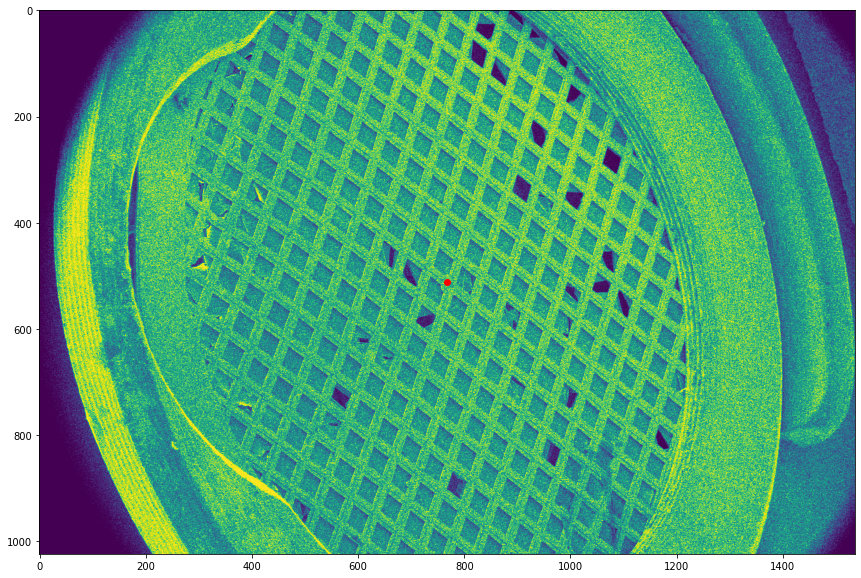

In [7]:
file_reference = [f for f in files if '_0.0' in f]
img_reference = cv2.imread(os.path.join(folder,file_reference[0]),cv2.IMREAD_GRAYSCALE)
plt.imshow(img_reference)
plt.plot(img_reference.shape[1]/2, img_reference.shape[0]/2,'ro')

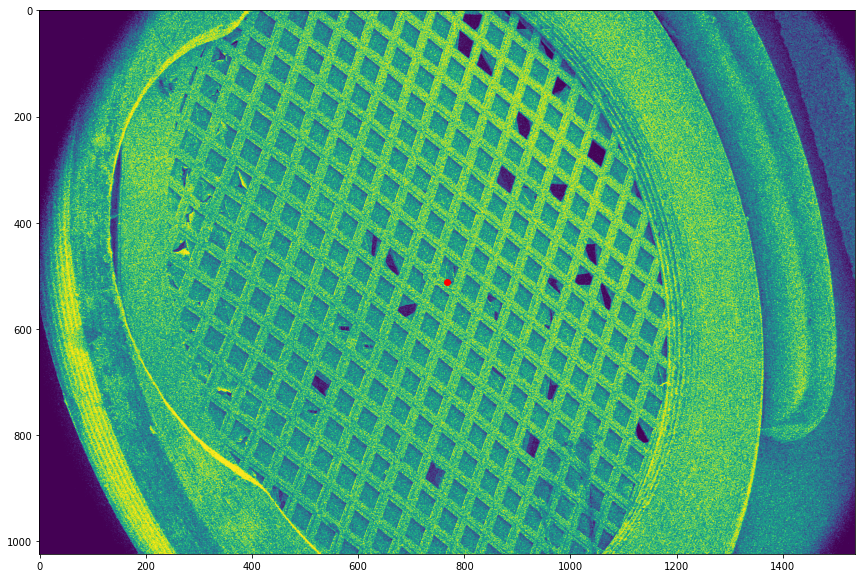

In [8]:
file_alignment = [f for f in files if '_'+ str(angle) in f]
img_alignment = cv2.imread(os.path.join(folder,file_alignment[0]), cv2.IMREAD_GRAYSCALE)
plt.imshow(img_alignment)
plt.plot(img_alignment.shape[1]/2, img_alignment.shape[0]/2,'ro')

# Calculate the pixel size with the known HFW of 3mm

In [9]:
pixel_size = 3e-3 / img_alignment.shape[0]
print("Pixel Size / micron: {}".format(pixel_size * 1e6))

Pixel Size / micron: 2.9296875


# Detect image features by ORB (Oriented FAST and Rotated Brief)

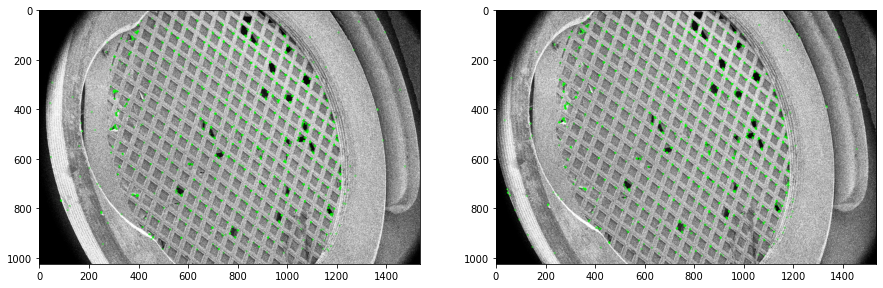

In [10]:
def detect_and_plot(image, axes,N_FEATURES=2000):
    orb = cv2.ORB_create(nfeatures=N_FEATURES)
    kp, des = orb.detectAndCompute(image, None)
    kp_img = cv2.drawKeypoints(image, kp, None, color=(0, 255, 0), flags=0)
    axes.imshow(kp_img)


fig, axes = plt.subplots(1,2)
detect_and_plot(img_reference,axes[0])
detect_and_plot(img_alignment, axes[1])

# Match features of 0° and the above specified angle images
## Helper function and execution

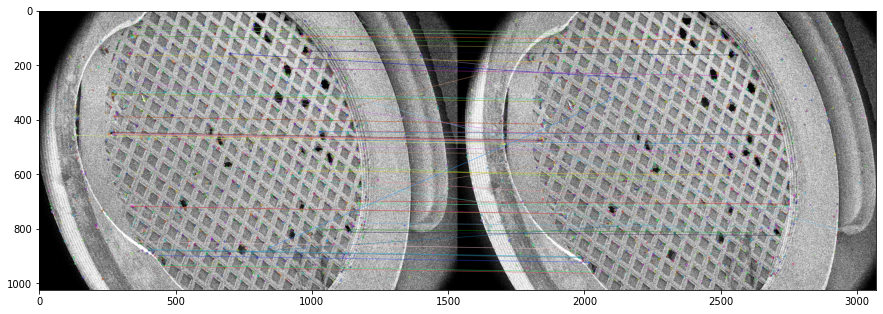

In [11]:
def matchFeatures(img_to_align, img_reference, MIN_MATCHES=50, N_FEATURES=5000, DISPLAY_MATCHES=False):
    orb = cv2.ORB_create(nfeatures=N_FEATURES)
    kp1, des1 = orb.detectAndCompute(img_to_align, None)
    kp2, des2 = orb.detectAndCompute(img_reference, None)

    index_params = dict(algorithm=6,
                        table_number=6,
                        key_size=12,
                        multi_probe_level=2)
    search_params = {}
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    # As per Lowe's ratio test to filter good matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)

    if len(good_matches) > MIN_MATCHES:
        src_points = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_points = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        mat, mask = cv2.findHomography(src_points, dst_points, cv2.RANSAC, 5.0)
        corrected_img = cv2.warpPerspective(img_to_align, mat, (img_reference.shape[1], img_reference.shape[0]))
        if DISPLAY_MATCHES:            
            match_img = cv2.drawMatches(img_to_align, kp1, img_reference, kp2, good_matches[:50], None)
            f, ax = plt.subplots()
            ax.imshow(match_img)
            plt.show()

        return corrected_img, mat.copy()
    else:
        print('Matching failed')
        return None, None
        
corrected_img, transformationMatrix = [], []
corrected_img, transformationMatrix = matchFeatures(img_reference=img_reference, img_to_align= img_alignment, DISPLAY_MATCHES=True)

## Plot the results

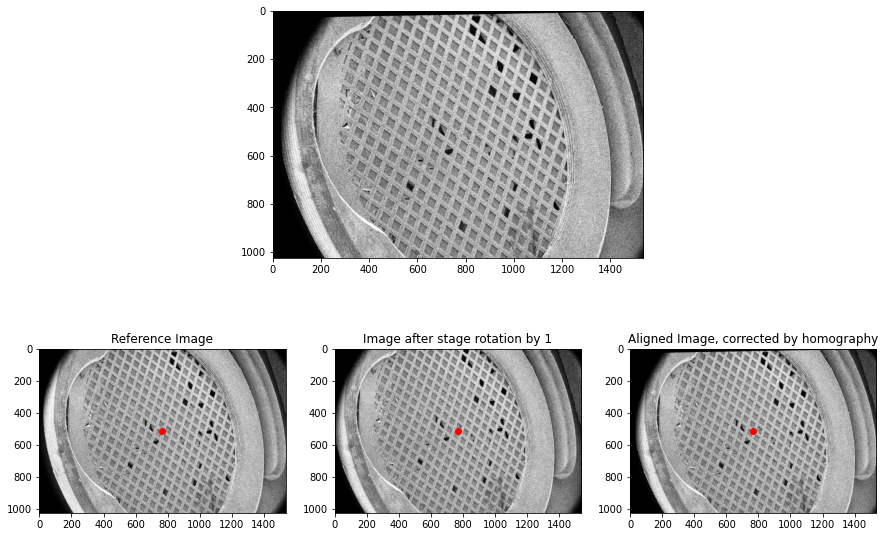

In [12]:
if corrected_img is not None:
    fig, axarr = plt.subplot_mosaic("AAA;BCD")
    axarr["A"].imshow(corrected_img, cmap='gist_gray') 
    axarr["B"].imshow(img_reference, cmap='gist_gray') 
    axarr["B"].plot(img_reference.shape[1]/2, img_reference.shape[0]/2,'ro')
    axarr["B"].set_title('Reference Image')
    axarr["D"].imshow(corrected_img, cmap='gist_gray') 
    axarr["D"].plot(corrected_img.shape[1]/2, corrected_img.shape[0]/2,'ro')
    axarr["D"].set_title('Aligned Image, corrected by homography')
    axarr["C"].imshow(img_alignment, cmap='gist_gray') 
    axarr["C"].plot(img_alignment.shape[1]/2, img_alignment.shape[0]/2,'ro')
    axarr["C"].set_title('Image after stage rotation by ' + str(angle))
    plt.show()

## Calculate the translation, scaling and rotation vector from the transformation matrix

In [13]:
def get_params_from_transformation_matrix(m, pixe_size=0.0, PRINT=False):
    if np.abs(m[2,0]) > 1e-3 or np.abs(m[2,1]) > 1e-3 :
        print("This is no valid transformation matrix, the projection component is too large.")
        return None
    else:
        a,b,c,d = m[0,0] , m[0,1], m[1,0], m[1,1]
        result = {}
        result['t'] = [m[0,2], m[1,2]]
        sx, sy = np.sqrt(a ** 2 + c ** 2) , np.sqrt(b ** 2 + d ** 2)
        result['s']  = [sx, sy]
        phi1,phi2 = np.rad2deg(np.arctan((c/sx)/(d/sy))), np.rad2deg(np.arctan((-b/sy)/(a/sx)))
        result['phi']  = [phi1,phi2, np.mean([phi1,phi2])]
        result['t_meter'] =[ t * pixel_size for t in result['t']]           
        x , y = symbols('x,y')
        a = np.deg2rad(result['phi'][2])
        Eq1 = Eq((1 - np.cos(a)) * x - y * np.sin(a) + result['t_meter'][1],0)
        Eq2 = Eq(x * np.sin(a) + (1- np.cos(a)) * y  - result['t_meter'][0],0)
        solution = solve((Eq1,Eq2), (x, y))
        result['c_x'], result['c_y'] = solution[x], solution[y]

        if PRINT:                        
            print("---Image Transformation---")
            print("{}\n".format(m))
            if pixel_size > 0.0:         
                print("Translation (x,y) / mm: {:.4f}, {:.4f}".format(m[0,2]*1e3*pixel_size,m[1,2]*1e3*pixel_size))
            print("Translation (x,y) / px: {}, {}".format(m[0,2],m[1,2]))
            print("Scaling (x,y): {}, {}".format(result['s'][0], result['s'][1]))
            print("Rotation Angle (x,y, mean): {}, {}, {}".format(phi1,phi2 ,round(result['phi'][2],2)))            
            print("Center of rotation / mm: {}, {}".format(solution[x]*1e3, solution[y]*1e3))
        return result


params = get_params_from_transformation_matrix(transformationMatrix, pixe_size=pixel_size, PRINT=True)

#from transforms3d import affines
#affines.decompose(transformationMatrix[1])



---Image Transformation---
[[ 9.99609041e-01  1.81868078e-02  2.58284495e+01]
 [-1.82605708e-02  1.00155732e+00  3.28371154e+01]
 [ 1.24799012e-06  4.86115223e-07  1.00000000e+00]]

Translation (x,y) / mm: 0.0757, 0.0962
Translation (x,y) / px: 25.828449539315073, 32.8371153609069
Scaling (x,y): 0.9997758163070374, 1.0017224249397942
Rotation Angle (x,y, mean): -1.0465443557046075, -1.0402948242240313, -1.04
Center of rotation / mm: -4.20310363401557, -5.24464631379652


In [14]:
cv2.getRotationMatrix2D((-42.797,96.622), -5.46, 1)

array([[ 0.99546287, -0.09515081,  8.99948626],
       [ 0.09515081,  0.99546287,  4.51055607]])

# Loop alignment over first 10° in 2.5° steps

In [15]:
# img_alignment = ()
# corrected_img = ()
# transformationMatrix = ()
# params = ()
# r = ()

# delta_angle = 1.

# for _ in range(len(files)-1):    
#     r += (delta_angle * ( _ + 1 ), )
#     #print("\n\nRotation: {}".format(r[_]))

#     file_alignment = [f for f in files if '_'+ str(r[_]) in f]
#     img_alignment += (cv2.imread(os.path.join(folder,file_alignment[0]), cv2.IMREAD_GRAYSCALE), )
    
#     c_img, t_m = matchFeatures(img_reference=img_reference, img_to_align= img_alignment[_] ,N_FEATURES=5000,DISPLAY_MATCHES=True) 

#     if c_img is not None:
#         corrected_img += (c_img,)
#         transformationMatrix += (t_m,)   
#         params += (get_params_from_transformation_matrix(transformationMatrix[_], pixe_size=pixel_size, PRINT=True), )
#         img_reference = img_alignment[_]
#     else:
#         break
#     _ += 1

# Plot angular diagram of angle and offsets

In [16]:
# angles_measured = [0.]
# x,y = [0.],[0.]
# plt.style.use('dark_background')

# for _ in range(len(params)):
#     x.append(params[_]['t_meter'][0])
#     y.append(params[_]['t_meter'][1])
#     angles_measured.append(params[_]['phi'][2])
# angles_measured, x, y

# fig,ax = plt.subplots(1,3)
# ax[0].hist([_ *1e3 for _ in x],bins=10)
# ax[0].set_title('Measured offsets x')
# ax[0].set_xlabel('Image offset in x / mm')
# ax[1].hist([_ *3 for _ in y],bins=10)
# ax[1].set_title('Measured offsets y')
# ax[1].set_xlabel('Image offset in y / mm')
# ax[2].hist(np.abs(angles_measured), bins=25)
# ax[2].set_title('Measured angle distribution')
# ax[2].set_xlabel('Measured image rotation angle / deg')

#for i, txt in enumerate(angles_measured):
#    ax[0].annotate(str(round(txt,1)), (x[i], y[i]))

In [17]:
# Calculate positions
new_pos = []
x_sum, y_sum = 0.0, 0.0

for _ in range(len(x)-1):
    i = len(positions_sorted) - _ -1
    new_pos.append(position_standard.copy())
    x_sum += x[_]
    y_sum += y[_]
    new_pos[_]['x'] -= x_sum
    new_pos[_]['y'] += y_sum
    new_pos[_]['r'] = positions_sorted[i]['r']

#new_pos
x_new, y_new =[_['x']*1e3 for _ in new_pos], [_['y']*1e3 for _ in new_pos]

fig, ax = plt.subplots()
ax.scatter(x_new, y_new )


NameError: name 'x' is not defined

In [ ]:
from scipy import optimize
from itertools import compress
def calculate_center_lsq(x,y, VERBOSE= True):
    def calc_R(xc, yc):
        """ calculate the distance of each 2D points from the center (xc, yc) """
        return np.sqrt((x_compressed-xc)**2 + (y_compressed-yc)**2)

    def f_2(c):
        """ calculate the algebraic distance between the data points and the mean circle centered at c=(xc, yc) """
        Ri = calc_R(*c)
        return Ri - Ri.mean()
    # coordinates of the barycenter
    x_m = np.mean(x)
    y_m = np.mean(y)
    center_estimate = x_m, y_m
    center_2, ier = optimize.leastsq(f_2, center_estimate)

    xc_2, yc_2 = center_2
    Ri_2       = calc_R(*center_2)
    R_2        = Ri_2.mean()
    residu_2   = sum((Ri_2 - R_2)**2)

    if VERBOSE:
        print("Center / mm: {},{}".format(xc_2*1e3,yc_2*1e3))
        print("Radius / mm: {}".format(R_2*1e3))
        print("Residuum: {}".format(residu_2))

    return {'xc': xc_2, 'yc': yc_2, 'r': R_2, 'residuum': residu_2}

x_compressed = list(compress(x, [np.abs(a) < 1.3 and np.abs(a) > .7 for a in angles_measured]))    
y_compressed = list(compress(y, [np.abs(a) < 1.3 and np.abs(a) > .7 for a in angles_measured]))

result_lsq_test_test_test = calculate_center_lsq(x_compressed,y_compressed)

In [ ]:
import math, pathlib, cv2, datetime
from turtle import Turtle
from re import VERBOSE
from time import sleep
import numpy as np
import csv

deltaR_deg = 90
itrations = 3
# Define Start position
stagepos = {'x':0, 'y': 0, 'z':0, 't': 0, 'r': 0}
pos = stagepos
print(pos)
pos['x'] = 2.02866e-3
pos['y'] = 5.0241e-3
pos['z'] = 35.413e-3
pos['t'] = 0.0
r = 0.0 # radians!
pos['r'] = r
print(pos)

pos2 = {'x':2.2606e-3, 'y': 3.7732e-3, 'z': 12.0161e-3, 't': 0, 'r': 0}

deltaR = np.deg2rad(deltaR_deg)
positions = []


import math
def rotate(origin, point, angle, VERBOSE=False):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    if VERBOSE:        
        print('New Coordinates: {}, {}, {} deg'.format(qx * 1e3, qy*1e3, np.rad2deg(angle)))
    return qx, qy

origin = [-0.241e-3, 1.223e-3]

for i in range(itrations):
    # Save position data and image
    positions.append(pos2)

    # Move to new angle
    r_new = (i+1) * deltaR
    newPosition = positions[0]
    x_rot, y_rot = rotate(origin, (newPosition['x'],newPosition['y']), r_new, True)    
    newPosition['x'] = x_rot   
    newPosition['y'] = y_rot
    print(r_new, newPosition)


In [ ]:
import math

def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

origin = [result_lsq['xc'],result_lsq['yc']]
point =[2.2975e-3, 3.7216e-3] 
angle = math.pi

x_rot, y_rot = rotate(origin, point, angle)

print('New Coordinates: {}, {}'.format(x_rot * 1e3, y_rot*1e3))

In [ ]:
test_image_nr = 10

matrix_test = np.identity(3)
matrix_test[0,2] = np.sum([p['t'][1] for p in params[0:test_image_nr]] )
matrix_test[1,2] = np.sum([p['t'][0] for p in params[0:test_image_nr]] )
img_test = cv2.warpAffine(img_alignment[test_image_nr],matrix_test[0:2,0:3],(1536,1024))
print(matrix_test)

matrix_test[0,2] = np.sum([p['s'][0] * p['t'][1] for p in params[0:test_image_nr]] )
matrix_test[1,2] = np.sum([p['s'][0] * p['t'][0] for p in params[0:test_image_nr]] )
img_test2 = cv2.warpAffine(img_alignment[test_image_nr],matrix_test[0:2,0:3],(1536,1024))



img_test3, t_m = matchFeatures(img_reference=img_alignment[0], img_to_align= img_alignment[test_image_nr] ,N_FEATURES=5000,DISPLAY_MATCHES=True) 


fig, ax = plt.subplots(3,2)
ax[0,0].imshow(img_alignment[0])
ax[0,0].plot(img_alignment[0].shape[1]/2, img_alignment[0].shape[0]/2,'ro')
ax[1,0].imshow(img_alignment[test_image_nr])

ax[0,1].imshow(img_test)
ax[0,1].plot(img_alignment[0].shape[1]/2, img_alignment[0].shape[0]/2,'ro')

ax[1,0].plot(img_alignment[0].shape[1]/2, img_alignment[0].shape[0]/2,'ro')
ax[1,0].plot(img_alignment[0].shape[1]/2 - matrix_test[1,2], img_alignment[0].shape[0]/2 - matrix_test[0,2],'go')

ax[1,1].imshow(img_test2)
ax[1,1].plot(img_alignment[0].shape[1]/2, img_alignment[0].shape[0]/2,'ro')

ax[2,1].imshow(img_test3)
ax[2,1].plot(img_alignment[0].shape[1]/2, img_alignment[0].shape[0]/2,'ro')

In [ ]:
from ctypes import resize
from matplotlib.patches import Arc as arc
plt.style.use('dark_background')
fig, ax = plt.subplots()

ax.plot(x,y,'ro',linewidth=2, markersize=5)
for i, txt in enumerate(angles_measured):
    ax.annotate(str(round(txt,1)), (x[i], y[i]))

ellipse = arc(xy=(result_lsq['xc'],result_lsq['yc']), width=2*result_lsq['r'], height=2*result_lsq['r'], angle=np.max(angles_measured),
                edgecolor='b', fc='None', lw=2, label='Fit', zorder = 2)
ax.add_patch(ellipse)
ax.axis('equal')

ax.plot(result_lsq['xc'],result_lsq['yc'], 'go')
ax.set_xlabel('Translation in x / mm')
ax.set_ylabel('Translation in y / mm')

ax.set_xlim((-2e-4,2e-4))
ax.set_ylim((0,5e-4))
plt.show()

In [ ]:
from ctypes import resize
from matplotlib.patches import Arc as arc
plt.style.use('dark_background')
fig, ax = plt.subplots()

ax.plot(x,y,'ro',linewidth=2, markersize=5)
for i, txt in enumerate(angles_measured):
    ax.annotate(str(round(txt,1)), (x[i], y[i]))

ellipse = arc(xy=(result_lsq['xc'],result_lsq['yc']), width=2*result_lsq['r'], height=2*result_lsq['r'], angle=np.max(angles_measured),
                edgecolor='b', fc='None', lw=2, label='Fit', zorder = 2)
ax.add_patch(ellipse)
ax.axis('equal')

ax.plot(result_lsq['xc'],result_lsq['yc'], 'go')
ax.set_xlabel('Translation in x / mm')
ax.set_ylabel('Translation in y / mm')

ax.set_xlim((-2e-4,2e-4))
ax.set_ylim((0,5e-4))
plt.show()